# Introduction
<img src = 'https://cdn-images-1.medium.com/max/900/1*TKr1dtcNgJCA8uYY1OhmSg.png'>

Generative Adversarial Networks (GANs) are generative models. They are uses unsupervised technique to generate new things. GAN models learns pattern in input data in such a way that they can generate new sample which resemble with the input data. The main aim of generative adversarial network is to match generated distribution with the original data distribution.

GANs are an exciting and rapidly changing field, delivering generative models ability to generate realistic examples across a range of problem domains, most notably in image-to-image translation tasks such as translating photos of summer to winter or day to night,coloring images and in generating fake photos that even human cannot categorized as fake image.
This <a href = 'https://thispersondoesnotexist.com/'> site </a> uses GAN to generate fake human faces which are similar to real human

### Components of GANs
<b> Generator </b>: Generator are neural network that learns to generate data which resemble with the input distribution. The generator model take fixed dimension random vector from Gaussian distribution as input and generate the sample out of it which resemble with input.

<b> Discriminator </b>: Discriminator are simple neural network that distinguish fake and real data.The discriminator model takes an example from the domain as input (real or generated) and predicts a binary class label of real or fake.

Generative adversarial networks are based on a game theoretic scenario in which the generator network must compete against an adversary. The generator network directly produces samples. Its adversary, the discriminator network, attempts to distinguish between samples drawn from the training data and samples drawn from the generator.

# Working of GANs
<img src = 'https://cdn.analyticsvidhya.com/wp-content/uploads/2017/06/11000153/g1.jpg'>

First of all we take batch of random vector from the Gaussian distribution and generate fake image out of it using generator. Since generator isn't trained so generated image donot resemble with the real input distribution. We take batches of image from the input distribution along with generated fake images and fed it to discriminator so that it learns to distinguish between real and fake images.
Now, after training discriminator, we take the batch of images that generator generated and fed them through discriminator again (here we donot fed real images), discriminator will provide an output probabilities, these values are then compared with the probability that the generator should generated (ie 1), error is calculated and backpropagated through the generator and the weight are updated.
This above process is repeated until generated images resemble with the input distribution.

## Application of GANs

## 1. Generating fake faces
<img src = "https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/06/Examples-of-Photorealistic-GAN-Generated-Faces.png">

## 2. Generate Examples for Image Datasets

## 3. Face Aging
<img src = 'https://www.baycare.net/media/5076/botox-aging-face-plastic-surgery.jpg' height = '600px' width = '500px'>



## 4. Super Resolution
<img src = 'https://miro.medium.com/max/700/1*E-JmUwv7zbwjzFm1hJLxPA.png'>


## 5. Image-to-Image Translation
<img src = 'https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/06/Example-of-Photographs-of-Daytime-Cityscapes-to-Nighttime-with-pix2pix.png'>

## 6.  Photos to Emojis
<img src = 'https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/06/Example-of-Celebrity-Photographs-and-GAN-Generated-Emojis.png'>




## 7.Text to image Translation

<img src = 'https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/06/Example-of-Textual-Descriptions-and-GAN-Generated-Photographs-of-Birds.png'>


## 8. Generate Cartoon characters
<img src = 'https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/06/Example-of-GAN-Generated-Anime-Character-Faces.png'>
   


## Objective: To generate fake faces of human

## Import necessary Libraries

In [1]:
import tensorflow as tf
import keras 
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import re
from keras.preprocessing.image import img_to_array

## Load data
Here I have used face-mask-lite-dataset, out of available 10000 images i have only use 9090 image. I have read image using opencv since opencv reads image in bgr format i have converted it back to rgb format using cvtColor function. These images are resize into 128 by 128 using resize function and are finally converted to array and are appended in empty array

In [26]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 128
_img = []
path = '../input/face-mask-lite-dataset/without_mask'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
        if i == 'seed9090.png':
            break
        else:    
            img = cv2.imread(path + '/'+i,1)
            # open cv reads images in BGR format so we have to convert it to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #resizing image
            img = cv2.resize(img, (SIZE, SIZE))
            img = (img - 127.5) / 127.5
            imh = img.astype(float)
            _img.append(img_to_array(img))

 91%|█████████ | 9090/10000 [07:55<00:47, 19.10it/s]


## Visailze our images

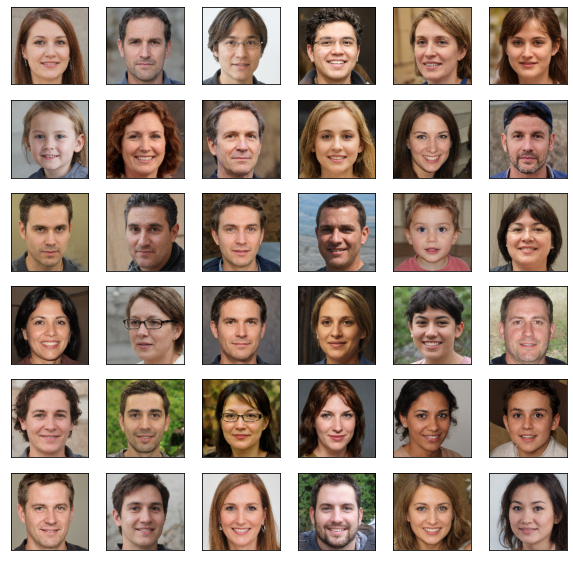

In [3]:
def plot_images(sqr = 5):
    plt.figure(figsize = (10,10))
    plt.title("Real Images",fontsize = 35)
    for i in range(sqr * sqr):
        plt.subplot(sqr,sqr,i+1)
        plt.imshow(_img[i]*0.5 + 0.5 )
        plt.xticks([])
        plt.yticks([])

# to plot images
plot_images(6)
    

Here, i have defined batch size so that these batches of images can be fed directly to the discriminator network

In [27]:
batch_size = 32
dataset=tf.data.Dataset.from_tensor_slices(np.array(_img)).batch(batch_size)

# Generator 
Here, I have defined generator network. It take random vector from normal distribution as input. This random vector is passed through dense layer and is reshaped and is finally fed through Convolution layers. Here, convolution layers does downsampling of our latent vector, after series of convolution batch normalization and leakyrelu layer our downsampled latent vector is upsampled using Conv2DTranspose.

The final output layer of Generator generate 128 by 128 by 3 image. The final layer of generator uses hyperbolic tangent as activation to squash the value in between -1 and 1. Generator model looks like simple autoencoder model, where input data is downsampled first and is finally upsampled .

In [4]:
latent_dim = 100
def Generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(128*128*3, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.Reshape((128,128,3)))
    # downsampling
    model.add(tf.keras.layers.Conv2D(128,4, strides=1, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=1, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2D(512,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    
    model.add(tf.keras.layers.LeakyReLU())
    #upsampling
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(256, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(256, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    
    model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2DTranspose(3,4,strides = 1, padding = 'same',activation = 'tanh'))
    
    

    return model

In [5]:
generator = Generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 49152)             4915200   
_________________________________________________________________
reshape (Reshape)            (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 128)     6144      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       262144    
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 128)       512       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 256)       5

# Discriminator
Here, discriminator model take 128 by 128 by 3 image that can be real or generated. This input image is downsampled using Convolution layer and is finally flattened and is fed to single neuron so that it can distinguish real and fake image. Since, final layer uses sigmoid function as activation, it output value in between 0 and 1. Here value greater than 0.5 refers to real and less than 0.5 refers to fake image. The output of discriminator is used in training of generator.

In [6]:
def Discriminator():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input((SIZE, SIZE, 3)))
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(512,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1,activation = 'sigmoid'))
    return model
  


In [7]:
discriminator = Discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 64, 64, 128)       6144      
_________________________________________________________________
batch_normalization_5 (Batch (None, 64, 64, 128)       512       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 128)       262144    
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 256)      

### Let's plot image generated by generator before training

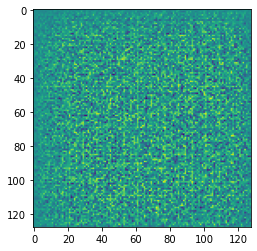

In [8]:
noise = np.random.normal(-1,1,(1,100))
img = generator(noise)
plt.imshow(img[0,:,:,0])
plt.show()

### Defining loss function and optimizer 

In [9]:
optimizer = tf.keras.optimizers.RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [10]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)
def discriminator_loss(fake_output, real_output):
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    return fake_loss + real_loss

### Defining training steps

In [11]:
def train_steps(images):
    noise = np.random.normal(0,1,(batch_size,latent_dim))
    with tf.GradientTape() as gen_tape , tf.GradientTape() as disc_tape:
        generated_images = generator(noise)
        fake_output = discriminator(generated_images)
        real_output = discriminator(images)
        
        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss(fake_output, real_output)
        
        
    gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)    
    gradient_of_discriminator = disc_tape.gradient(dis_loss, discriminator.trainable_variables)
    
    optimizer.apply_gradients(zip(gradient_of_generator,generator.trainable_variables))
    optimizer.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))
    
    loss = {'gen loss':gen_loss,
           'disc loss': dis_loss}
    return loss

## function to plot generated images


In [35]:
def plot_generated_images(square = 5, epochs = 0):
    
    
  plt.figure(figsize = (10,10))
  for i in range(square * square):
    if epochs != 0:    
        if(i == square //2):
            plt.title("Generated Image at Epoch:{}\n".format(epochs), fontsize = 32, color = 'black')
    plt.subplot(square, square, i+1)
    noise = np.random.normal(0,1,(1,latent_dim))
    img = generator(noise)
    plt.imshow(np.clip((img[0,...]+1)/2, 0, 1))
    
    plt.xticks([])
    plt.yticks([])
    plt.grid()

In [17]:
import time
def train(epochs,dataset):
    
    for epoch in range(epochs):
        start = time.time()
        print("\nEpoch : {}".format(epoch + 1))
        for images in dataset:
            loss = train_steps(images)
        print(" Time:{}".format(np.round(time.time() - start),2)) 
        print("Generator Loss: {} Discriminator Loss: {}".format(loss['gen loss'],loss['disc loss']))
            
        
        
    

## Training

In [31]:

train(5,dataset)
# i had train model previously for more than 10 epochs so generated images are quiet good


Epoch : 1
 Time:255.0
Generator Loss: 0.5248658657073975 Discriminator Loss: 1.1912497282028198

Epoch : 2
 Time:255.0
Generator Loss: 1.4183704853057861 Discriminator Loss: 0.5930993556976318

Epoch : 3
 Time:255.0
Generator Loss: 0.5612043142318726 Discriminator Loss: 0.9971701502799988

Epoch : 4
 Time:255.0
Generator Loss: 0.8967819809913635 Discriminator Loss: 0.8006410598754883


# Some Generated Images


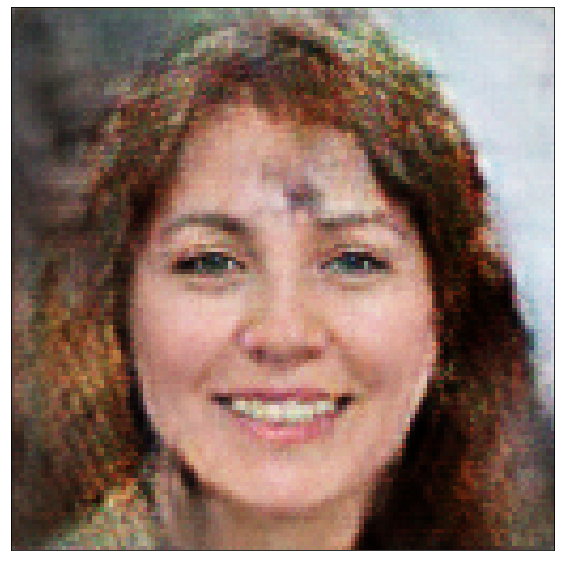

In [87]:
plot_generated_images(1)

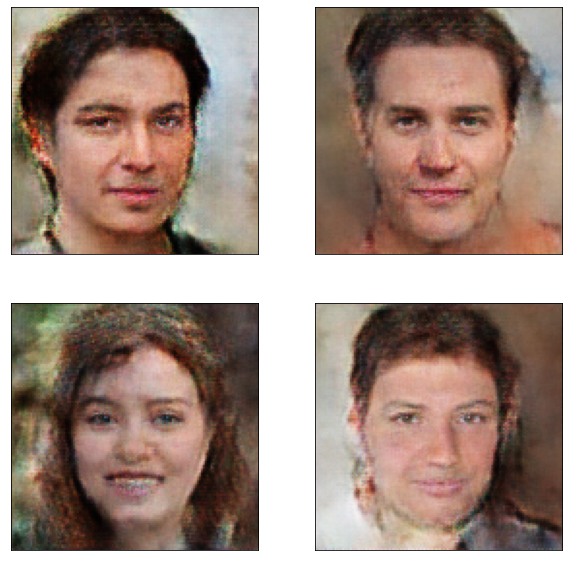

In [66]:
plot_generated_images(2)

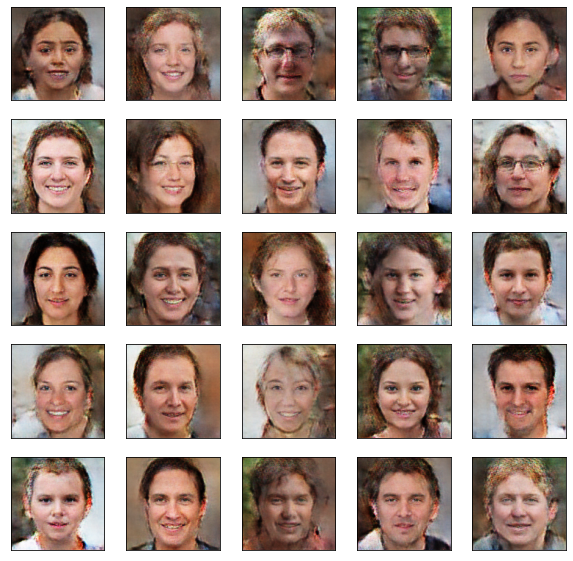

In [37]:
plot_generated_images(5)

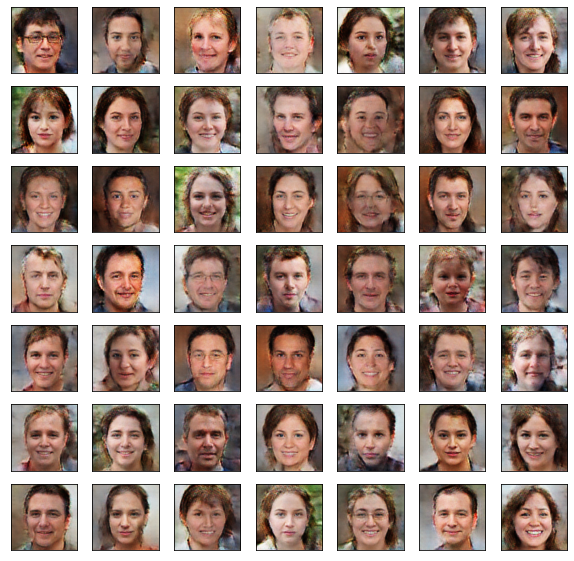

In [38]:
plot_generated_images(7)

In [ ]:
generator.save('generator.h5')
discriminator.save("discriminator.h5")

#### ref: <a href = 'https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/'> machinelearningmastery </a>, <a href = 'https://towardsdatascience.com/generative-adversarial-network-gan-for-dummies-a-step-by-step-tutorial-fdefff170391'> towardsdatascience </a>

### Thanks for your visit
## Any suggestion to improve generated images is really appreciated
## Feel free to comment and upvote.....
# Thank You